<a href="https://colab.research.google.com/github/alamau01/Thesis-in-EE/blob/master/Stock_Price_Prediction_LSTM_TensorFlow_Credit_Suisse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 1.x
!pip show tensorflow

Name: tensorflow
Version: 1.15.2
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /tensorflow-1.15.2/python3.6
Requires: wheel, wrapt, keras-preprocessing, termcolor, numpy, protobuf, google-pasta, absl-py, opt-einsum, six, tensorflow-estimator, tensorboard, keras-applications, astor, gast, grpcio
Required-by: stable-baselines, magenta, fancyimpute


In [0]:
import pandas_datareader as web
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import tensorflow as tf

dataset = web.DataReader('CS', data_source = 'yahoo', start = '2000-01-01', end = '2020-03-31')
dataset

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-01-03,48.583984,48.339844,48.339844,48.339844,2000.0,26.061193
2000-01-04,47.607422,46.630859,46.875000,46.875000,6400.0,25.271458
2000-01-05,47.363281,46.386719,46.875000,46.875000,13000.0,25.271458
2000-01-06,47.119141,46.386719,47.119141,47.119141,1400.0,25.403076
2000-01-07,47.241211,46.386719,47.241211,47.241211,2200.0,25.468893
...,...,...,...,...,...,...
2020-03-25,8.560000,7.890000,8.150000,8.260000,6514800.0,8.260000
2020-03-26,8.970000,8.490000,8.530000,8.890000,7800400.0,8.890000
2020-03-27,8.540000,8.170000,8.370000,8.330000,3725100.0,8.330000


                 High        Low       Open      Close   Volume  Adj Close
Date                                                                      
2000-01-03  48.583984  48.339844  48.339844  48.339844   2000.0  26.061193
2000-01-04  47.607422  46.630859  46.875000  46.875000   6400.0  25.271458
2000-01-05  47.363281  46.386719  46.875000  46.875000  13000.0  25.271458
2000-01-06  47.119141  46.386719  47.119141  47.119141   1400.0  25.403076
2000-01-07  47.241211  46.386719  47.241211  47.241211   2200.0  25.468893


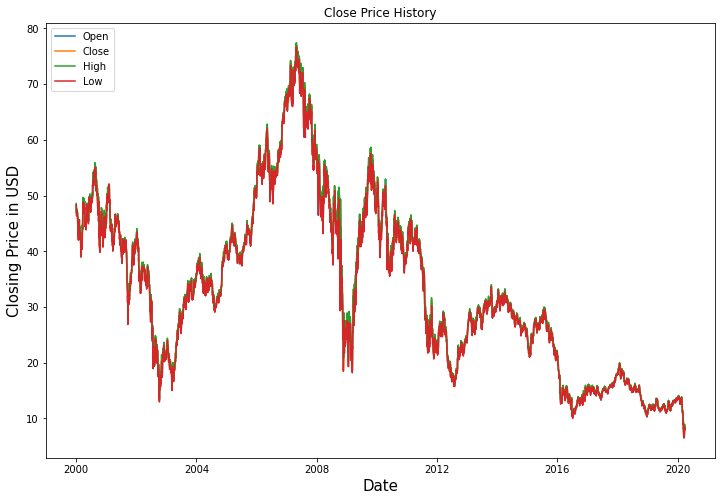

In [0]:
# Data Exploration
# Data is sorted by date since the order of the data is essential for time series models
cs_data = dataset.sort_values('Date')
print(cs_data.head())

#Data Visualization
plt.figure(figsize = (12, 8))
plt.plot(cs_data['Open'])
plt.plot(cs_data['Close'])
plt.plot(cs_data['High'])
plt.plot(cs_data['Low'])
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Closing Price in USD', fontsize = 15)
plt.title('Close Price History')
plt.legend(['Open', 'Close', 'High', 'Low'], loc = 'upper left')
plt.show()

In [0]:
from sklearn.preprocessing import MinMaxScaler

#Splitting data into training and test data sets
#high_prices = apple_data.loc[:,'High'].values
#low_prices = apple_data.loc[:,'Low'].values
#avg_prices = (high_prices+low_prices)/2.0
closing_stock_prices = cs_data.loc[:, 'Close'].values
data_train = closing_stock_prices[: 4022] # The first 4022 datapoints are taken as training samples
data_test = closing_stock_prices[4022 :] # The rest are taken as testing samples

# The datasets are scaled to be between 0 and 1. 
# Both test and train data are normalized with respect to the training dataset
# as the test data is not to be accessed
sc = MinMaxScaler()
data_train = data_train.reshape(-1, 1)
data_test = data_test.reshape(-1, 1)

#The scaler is trained with training and smooth data
smooth_window = 1000
for di in range(0, 4000, smooth_window):
  sc.fit(data_train[di : di + smooth_window, :])
  data_train[di : di + smooth_window, :] = sc.transform(data_train[di : di + smooth_window, :])

# The last bit of remaining data is normalized
sc.fit(data_train[di + smooth_window:, :])
data_train[di + smooth_window:, :] = sc.transform(data_train[di + smooth_window:, :])

# The data is reshaped back to the shape of [data_size]
data_train = data_train.reshape(-1)
data_test = sc.transform(data_test).reshape(-1)

In [0]:
# Exponential moving average is used for smoothing
# so that the data exhibits a smoother curve than the original erratic data
ema = 0.0
gamma = 0.1
for ti in range(4022):
  ema = gamma * data_train[ti] + (1 - gamma) * ema
  data_train[ti] = ema

# Used for visualization and test purposes
all_mid_data = np.concatenate([data_train, data_test], axis = 0)

In [0]:
class DataGeneratorSeq(object):

  def __init__(self, prices, batch_size, num_unroll):
    self._prices = prices
    self._prices_length = len(self._prices) - num_unroll
    self._batch_size = batch_size
    self._num_unroll = num_unroll
    self._segments = self._prices_length // self._batch_size
    self._cursor = [offset * self._segments for offset in range(self._batch_size)]

  def next_batch(self):
    batch_data = np.zeros((self._batch_size), dtype = np.float32)
    batch_labels = np.zeros((self._batch_size), dtype = np.float32)

    for b in range(self._batch_size):
      if self._cursor[b] + 1 >= self._prices_length:
        self._cursor[b] = np.random.randint(0, (b + 1) * self._segments)

      batch_data[b] = self._prices[self._cursor[b]]
      batch_labels[b] = self._prices[self._cursor[b] + np.random.randint(0, 5)]

      self._cursor[b] = (self._cursor[b] + 1) %self._prices_length

    return batch_data, batch_labels

  def unroll_batches(self):
    unroll_data, unroll_labels = [], []
    init_data, init_label = None, None
    for ui in range(self._num_unroll):
      data, labels = self.next_batch()
      unroll_data.append(data)
      unroll_labels.append(labels)

    return unroll_data, unroll_labels

  def reset_indices(self):
    for b in range(self._batch_size):
      self._cursor[b] = np.random.randint(0, min((b + 1) * self._segments, self._prices_length - 1))

datagenerator = DataGeneratorSeq(data_train, 5, 5)
u_data, u_labels = datagenerator.unroll_batches()

for ui, (dat, lbl) in enumerate(zip(u_data, u_labels)):
  print('\n\nUnrolled index %d' %ui)
  dat_ind = dat
  lbl_ind = lbl
  print('\tInputs: ', dat)
  print('\n\tOutput: ', lbl)



Unrolled index 0
	Inputs:  [0.08317085 0.11313073 0.6018839  0.6658506  0.3072107 ]

	Output:  [0.15454271 0.11465424 0.58568794 0.6658506  0.3080641 ]


Unrolled index 1
	Inputs:  [0.15454271 0.11465424 0.59750277 0.6750673  0.30694678]

	Output:  [0.33001146 0.11686106 0.59309036 0.6931338  0.30694678]


Unrolled index 2
	Inputs:  [0.21877739 0.11686106 0.59309036 0.6827792  0.3080641 ]

	Output:  [0.41921154 0.12105239 0.58568794 0.6931338  0.3283463 ]


Unrolled index 3
	Inputs:  [0.27716893 0.12105239 0.58769023 0.6888939  0.3118336 ]

	Output:  [0.33001146 0.12120342 0.5847395  0.6931338  0.32014912]


Unrolled index 4
	Inputs:  [0.33001146 0.12120342 0.58568794 0.6931338  0.31441322]

	Output:  [0.37756974 0.12120342 0.58201164 0.69452876 0.3283463 ]


In [0]:
# Defining the Hyperparameters
Dim = 1 # Dimensionality of the data
num_unrollings = 350 # Number of time steps looked into the future, i.e. 50 days into the future
batch_size = 600 # Number of samples in a batch
num_nodes = [350, 350, 300] # Number of hidden nodes
n_layers = len(num_nodes) # Number of layers
dropout = 0.2 

tf.reset_default_graph() # Essential for running this multiple times

# Input Data
in_train, out_train = [], []

# The input is unrolled over time defining placeholders for each time step
for ui in range(num_unrollings):
  in_train.append(tf.placeholder(tf.float32, shape = [batch_size, Dim], name = 'in_train_%d' %ui))
  out_train.append(tf.placeholder(tf.float32, shape = [batch_size, 1], name = 'out_train_%d' %ui))

# Defining parameters of the LSTM and regression layer
cells_LSTM = [
    tf.contrib.rnn.LSTMCell(num_units=num_nodes[li],
                            state_is_tuple=True,
                            initializer= tf.contrib.layers.xavier_initializer()
                           )
 for li in range(n_layers)]

cells_drop_LSTM = [tf.contrib.rnn.DropoutWrapper(
    lstm, input_keep_prob = 1.0, output_keep_prob = 1.0 - dropout, state_keep_prob = 1.0 - dropout
) for lstm in cells_LSTM]

drop_multi_cell = tf.contrib.rnn.MultiRNNCell(cells_drop_LSTM)
multi_cell = tf.contrib.rnn.MultiRNNCell(cells_LSTM)

w = tf.get_variable('w', shape = [num_nodes[-1], 1], initializer = tf.contrib.layers.xavier_initializer())
b = tf.get_variable('b', initializer = tf.random_uniform([1], -0.1, 0.1))

# Calculating the LSTM output for the regression layer to output the final prediction
# Creating cell state and hidden state variables to maintain the state of the LSTM
c, h = [], []
ini_state = []
for li in range(n_layers):
  c.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable = False))
  h.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable = False))
  ini_state.append(tf.contrib.rnn.LSTMStateTuple(c[li], h[li]))

# Several tensor transformations are performed as the dynamic_rnn function
# needs the output to be of a particular format.
all_in = tf.concat([tf.expand_dims(t, 0) for t in in_train], axis = 0)
all_LSTM_out, state = tf.nn.dynamic_rnn(
    drop_multi_cell, all_in, initial_state = tuple(ini_state),
    time_major = True, dtype = tf.float32)

all_LSTM_out = tf.reshape(all_LSTM_out, [batch_size * num_unrollings, num_nodes[-1]])
all_out = tf.nn.xw_plus_b(all_LSTM_out, w,b)
split_out = tf.split(all_out, num_unrollings, axis = 0)

# Loss Calculation and Optimizer
print('Define training loss')
loss = 0.0
with tf.control_dependencies([tf.assign(c[li], state[li][0]) for li in range(n_layers)]+
                             [tf.assign(h[li], state[li][1]) for li in range(n_layers)]):
  for ui in range(num_unrollings):
    loss += tf.reduce_mean(0.5 * (split_out[ui] - out_train[ui]) ** 2)

print('Learning rate decay operations')
glbl_step = tf.Variable(0, trainable = False)
inc_gstep = tf.assign(glbl_step, glbl_step + 1)
tf_lrn_rate = tf.placeholder(shape = None, dtype = tf.float32)
tf_min_lrn_rate = tf.placeholder(shape = None, dtype = tf.float32)

lrn_rate = tf.maximum(tf.train.exponential_decay(tf_lrn_rate, glbl_step, decay_steps = 1, decay_rate = 0.5, staircase = True), tf_min_lrn_rate)

#Optimizer
print('TF Optimization Operations')
optimizer = tf.train.AdamOptimizer(lrn_rate)
grad, v = zip(*optimizer.compute_gradients(loss))
grad, _ = tf.clip_by_global_norm(grad, 5.0)
optimizer = optimizer.apply_gradients(zip(grad, v))
print('\tAll done')

# Prediction related calculations
print('Define prediction related TF functions')

sample_in = tf.placeholder(tf.float32, shape = [1, Dim])

# Maintaining the LSTM state for predictions:
c_smple, h_smple, ini_state_smple = [], [], []
for li in range(n_layers):
  c_smple.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable = False))
  h_smple.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable = False))
  ini_state_smple.append(tf.contrib.rnn.LSTMStateTuple(c_smple[li], h_smple[li]))

reset_states_smple = tf.group(*[tf.assign(c_smple[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)],
                               *[tf.assign(h_smple[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)])

sample_out, state_smple = tf.nn.dynamic_rnn(multi_cell, tf.expand_dims(sample_in, 0),
                                   initial_state=tuple(ini_state_smple),
                                   time_major = True,
                                   dtype=tf.float32)

with tf.control_dependencies([tf.assign(c_smple[li], state_smple[li][0]) for li in range(n_layers)]+
                              [tf.assign(h_smple[li], state_smple[li][1]) for li in range(n_layers)]):  
  pred_sample = tf.nn.xw_plus_b(tf.reshape(sample_out, [1,-1]), w, b)

print('\tAll done')

Define training loss
Learning rate decay operations
TF Optimization Operations
	All done
Define prediction related TF functions
	All done


In [0]:
# Running the LSTM
epochs = 60
valid_sum = 1 # Interval of test predictions
n_pred_once = 50 # Number of steps to continuously predict for
train_seq_len = data_train.size # Full length of the training data
mse_train_ot = [] # Accumulate train losses
mse_test_ot = [] # Accumulate test losses
pred_ot = [] # Accumulate predictions
sesh = tf.InteractiveSession()
tf.global_variables_initializer().run()

# Applied for decaying learning rate
loss_nondec_count = 0
loss_nondec_thresh = 2 

print('Initialized')
avg_loss = 0

# Defining Data Generator
data_gen = DataGeneratorSeq(data_train, batch_size, num_unrollings)
x_axis_seq = []

# Points where the predictions are started from
test_pnts_seq = np.arange(4022, 5022, 50).tolist()

for epoch in range(epochs):
  # ========================= Training ===========================
  for step in range(train_seq_len // batch_size):
    u_data, u_labels = data_gen.unroll_batches()

    feed_dict = {}
    for ui, (dat, lbl) in enumerate(zip(u_data, u_labels)):
      feed_dict[in_train[ui]] = dat.reshape(-1, 1)
      feed_dict[out_train[ui]] = lbl.reshape(-1, 1)

    feed_dict.update({tf_lrn_rate: 0.0001, tf_min_lrn_rate: 0.000001})
    _, l = sesh.run([optimizer, loss], feed_dict = feed_dict)
    avg_loss += l

  # ======================== Validation ==========================
  if (epoch + 1) % valid_sum == 0:
    avg_loss = avg_loss / (valid_sum * (train_seq_len // batch_size))

    # The average loss
    if (epoch + 1) % valid_sum == 0:
      print('Average loss at step %d: %f' %(epoch + 1, avg_loss))

      mse_train_ot.append(avg_loss)

      avg_loss = 0 # Reset loss

      pred_seq = []

      mse_test_loss_seq = []

      # ==================== Updating State and Making Predictions ==================
      for wi in test_pnts_seq:
        mse_test_loss = 0.0
        our_pred = []

        if (epoch + 1) - valid_sum == 0:
          # Only x_axis values are computed in the first validation epoch
          x_axis = []

        # Recent past behavior of stock prices are fed
        # to make predictions from that point onwards
        for tri in range(wi - num_unrollings + 1, wi - 1):
          current_price = all_mid_data[tri]
          feed_dict[sample_in] = np.array(current_price).reshape(1, 1)
          _ = sesh.run(pred_sample, feed_dict = feed_dict)

        feed_dict = {}
        current_price = all_mid_data[wi - 1]
        feed_dict[sample_in] = np.array(current_price).reshape(1, 1)

        # Prediction are made for this many steps
        # Each prediction uses previous prediction as its current input
        for predi in range(n_pred_once):
          pred = sesh.run(pred_sample, feed_dict = feed_dict)
          our_pred.append(np.asscalar(pred))
          feed_dict[sample_in] = np.asarray(pred).reshape(-1, 1)

          if (epoch + 1) - valid_sum == 0:
            # Only x_axis values in the first validation epoch are calculated
            x_axis.append(wi + predi)

          mse_test_loss += 0.5 * (pred - all_mid_data[wi + predi]) ** 2

        sesh.run(reset_states_smple)
        pred_seq.append(np.array(our_pred))
        mse_test_loss /= n_pred_once
        mse_test_loss_seq.append(mse_test_loss)

        if (epoch + 1) - valid_sum == 0:
          x_axis_seq.append(x_axis)

      current_test_mse = np.mean(mse_test_loss_seq)

      # Learning rate decay logic
      if len(mse_test_ot) > 0 and current_test_mse > min(mse_test_ot):
        loss_nondec_count += 1
      else:
        loss_nondec_count = 0

      if loss_nondec_count > loss_nondec_thresh:
        sesh.run(inc_gstep)
        loss_nondec_count = 0
        print('\tDecreasing learning rate by 0.5')

      mse_test_ot.append(current_test_mse)
      print('\tTest MSE: %.5f' %np.mean(mse_test_loss_seq))
      pred_ot.append(pred_seq)
      print('\tFinished Predictions')

/tensorflow-1.15.2/python3.6/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Initialized
Average loss at step 1: 36.534003


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:79: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


	Test MSE: 3.13454
	Finished Predictions
Average loss at step 2: 6.004689
	Test MSE: 1.81617
	Finished Predictions
Average loss at step 3: 2.671997
	Test MSE: 2.41709
	Finished Predictions
Average loss at step 4: 1.929925
	Test MSE: 1.48522
	Finished Predictions
Average loss at step 5: 2.259142
	Test MSE: 1.94576
	Finished Predictions
Average loss at step 6: 1.095141
	Test MSE: 1.53731
	Finished Predictions
Average loss at step 7: 0.988446
	Decreasing learning rate by 0.5
	Test MSE: 1.70134
	Finished Predictions
Average loss at step 8: 0.807876
	Test MSE: 1.68306
	Finished Predictions
Average loss at step 9: 0.752445
	Test MSE: 1.61480
	Finished Predictions
Average loss at step 10: 0.680586
	Decreasing learning rate by 0.5
	Test MSE: 1.57737
	Finished Predictions
Average loss at step 11: 0.618390
	Test MSE: 1.53920
	Finished Predictions
Average loss at step 12: 0.593479
	Test MSE: 1.49569
	Finished Predictions
Average loss at step 13: 0.558080
	Test MSE: 1.44478
	Finished Predictions
A

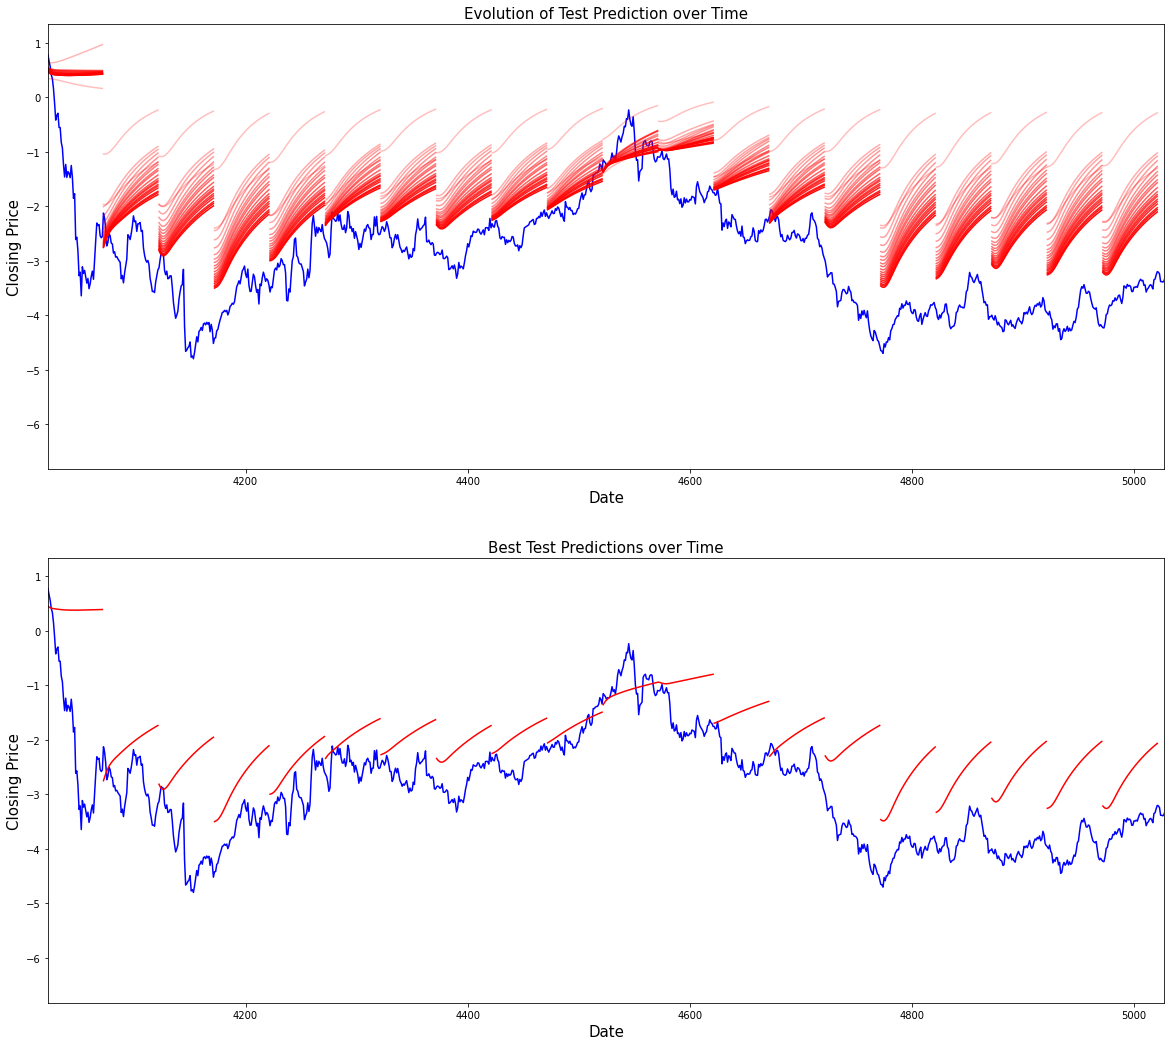

1.0699575012631914


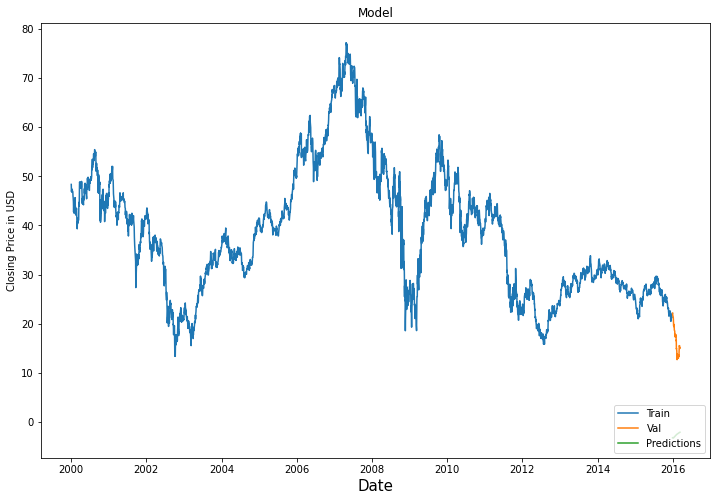

In [0]:
import matplotlib.pyplot as plt

best_pred_epoch = 58
rmse_score = np.sqrt(np.mean(((pred_ot[best_pred_epoch] - data_test[best_pred_epoch]) ** 2)))

plt.figure(figsize = (20, 18))
plt.subplot(2, 1, 1)
plt.plot(range(dataset.shape[0]), all_mid_data, color = 'b')

start_alpha = 0.25
alpha = np.arange(start_alpha, 1.1, (1.0 - start_alpha) / len(pred_ot[::3]))
for pi, p in enumerate(pred_ot[::3]):
  for xval, yval in zip(x_axis_seq, p):
    plt.plot(xval, yval, color = 'r', alpha = alpha[pi])

plt.title('Evolution of Test Prediction over Time', fontsize = 15)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Closing Price', fontsize = 15)
plt.subplot(2, 1, 2)

plt.plot(range(dataset.shape[0]), all_mid_data, color = 'b')
for xval, yval in zip(x_axis_seq, pred_ot[best_pred_epoch]):
  plt.plot(xval, yval, color = 'r')

plt.title('Best Test Predictions over Time', fontsize = 15)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Closing Price', fontsize = 15)
plt.xlim(4022, 5027)
plt.show()
print(rmse_score)

train = dataset.filter(['Close'])[: len(data_train)]
valid = dataset.filter(['Close'])[len(data_train) : 4072]
valid['Predictions'] = our_pred

plt.figure(figsize = (12, 8))
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Closing Price in USD')
plt.legend(['Train', 'Val', 'Predictions'], loc = 'lower right')
plt.title('Model')
plt.show()